In [ ]:
%pip install --upgrade transformers datasets accelerate deepspeed sentencepiece
!pip install wandb

In [2]:
import os
import torch
import requests
import numpy as np
import transformers
from PIL import Image
import torch.nn as nn
import skimage.io as io
from tqdm.auto import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt

# dataset preprocessing for CLIP

In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import os


(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()


image_paths = []
labels = []

save_dir = 'cifar10_images'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

170498071/170498071 [==============================] - 2s 0us/step


In [4]:
for i in range(len(train_images)):
    image_path = os.path.join(save_dir, f"train_image_{i}.jpg")
    tf.keras.preprocessing.image.save_img(image_path, train_images[i])
    image_paths.append(image_path)
    labels.append(train_labels[i][0])


for i in range(len(test_images)):
    image_path = os.path.join(save_dir, f"test_image_{i}.jpg")
    tf.keras.preprocessing.image.save_img(image_path, test_images[i])
    image_paths.append(image_path)
    labels.append(test_labels[i][0])

In [5]:
print(len(train_images), "\n")
print(len(test_images), "\n")
print(len(image_paths))

50000 

10000 

60000


In [6]:
for i in range(len(image_paths)):
    print(f"{image_paths[i]} - Label: {labels[i]}")
    break

cifar10_images/train_image_0.jpg - Label: 6


In [7]:
classes = {0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer", 5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"}

In [8]:
labels[59000]

8

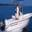

In [9]:
from PIL import Image
Image.open(image_paths[59000])

convert labels to textual data


In [10]:
titles = []
for im in tqdm(range(len(image_paths))):
    titles.append(classes[labels[im]])

  0%|          | 0/60000 [00:00<?, ?it/s]

In [11]:
assert len(titles) == len(labels) == len(image_paths)
assert titles[59000] == 'ship'
titles[59000]

'ship'

concepts

In [12]:
def remove_prefixes(strings):
    prefixes = ['a', 'an', 'the']
    result = []

    for string in strings:
        words = string.split()
        if words[0].lower() in prefixes:
            result.append(' '.join(words[1:]))
        else:
            result.append(string)

    return result

with open("conceptnet_cifar10_filtered_new.txt", "r") as f:
    concepts = f.read().lower().split("\n")
    concepts = remove_prefixes(concepts)

# CLIPDataset

collate_fn could be good for trainer but later

In [13]:
class CLIPDataset():
    def __init__(self, list_image_path, list_txt):
        self.image_path = list_image_path
        self.title  = list_txt

    def __len__(self):
        return len(self.title)

    def __getitem__(self, idx):
        image = Image.open(self.image_path[idx])
        title = self.title[idx]
        return image, title


def collate_fn(batch):
    return {
        'image': [x[0] for x in batch],
        'title': [x[1] for x in batch]
    }

dataset = CLIPDataset(list_image_path=image_paths, list_txt=labels) # but it can be with <<titles>> to get textual annotations for class labels
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [50000, 3000, 7000])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn, pin_memory=True)

In [14]:
assert len(dataset) == len(image_paths)
len(dataset)

60000

In [15]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [50000, 3000, 7000])
print("Train set: {}".format(len(train_dataset)), "\n")
print("Validation set: {}".format(len(val_dataset)), "\n")
print("Test set: {}".format(len(test_dataset)))

Train set: 50000 

Validation set: 3000 

Test set: 7000


test func

In [54]:
train_dataset[0]

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=32x32>, 6)

In [55]:
def preprocess_dataset(dataset, concepts: list=concepts):
    preprocessed_items = []
    for item in tqdm(dataset):
        preprocessed_item = preprocess_item(item, processor, concepts)
        preprocessed_items.append(preprocessed_item)
    return preprocessed_items

def preprocess_item(item, processor, concepts: list=concepts):
    return processor(text=concepts, images=item[0], return_tensors="pt", padding=True), item[1]

In [56]:
val_dataset_preprocessed = preprocess_dataset(val_dataset, concepts)

  0%|          | 0/3000 [00:00<?, ?it/s]

In [83]:
def collate_fn_test(sample):
    return {
        'image': sample[0],
        'title': sample[1]
    }

In [96]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

preprocessing dataloaders

In [16]:
from transformers import CLIPModel, CLIPProcessor, AutoTokenizer

def preprocess_loader(loader, concepts: list=concepts):
    preprocessed_batches = []
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    for batch in tqdm(loader):
        preprocessed_batch = preprocess_batch(batch, processor, concepts)
        preprocessed_batches.append(preprocessed_batch)
    return preprocessed_batches

def preprocess_batch(batch, processor, concepts: list=concepts):
    return processor(text=concepts, images=batch['image'], return_tensors="pt", padding=True), batch['title']

In [17]:
train_loader_preprocessed = preprocess_loader(train_loader, concepts)

  0%|          | 0/1563 [00:00<?, ?it/s]

In [18]:
val_loader_preprocessed = preprocess_loader(val_loader, concepts)

  0%|          | 0/94 [00:00<?, ?it/s]

In [19]:
test_loader_preprocessed = preprocess_loader(test_loader, concepts)

  0%|          | 0/219 [00:00<?, ?it/s]

# Model

In [ ]:
from transformers import CLIPConfig, CLIPTextConfig, CLIPVisionConfig

config_text = CLIPTextConfig()
config_vision = CLIPVisionConfig()
model_configuration = CLIPConfig.from_text_vision_configs(config_text, config_vision)
model_configuration

In [31]:
from transformers import CLIPModel, CLIPProcessor, AutoTokenizer

model = CLIPModel(model_configuration).from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

In [61]:
class TuningCLIPhead(nn.Module):
    def __init__(self, model_name: str="openai/clip-vit-base-patch32", concepts: list=concepts, classes: dict=classes):
        super().__init__()
        self.clip = transformers.CLIPModel.from_pretrained(model_name)
        self.processor = transformers.CLIPProcessor.from_pretrained(model_name)
        for param in self.clip.parameters():
            param.requires_grad=False
        self.head = nn.Linear(len(concepts), len(classes), bias=False)

    def forward(self, **batch):
        out = self.clip(**batch).logits_per_image
        return self.head(out)

In [122]:
for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

# Training

## try vanilla

In [125]:
clf = TuningCLIPhead()
optimizer = torch.optim.Adam(clf.parameters(), lr=1e-3)

In [126]:
epochs = 4

for epoch in range(epochs):
    for i, batch in enumerate(tqdm(train_loader_preprocessed)):
        optimizer.zero_grad()

        inputs, titles = batch
        #logits = F.softmax(clf(**inputs).squeeze(0), dim=-1)
        logits = clf(**inputs).squeeze(0)
        #targets = F.one_hot(torch.tensor(titles, dtype=torch.int64), num_classes=len(classes)).to(dtype=torch.float32)
        targets = torch.tensor(titles, dtype=torch.long)
        #loss = F.cross_entropy(logits, targets)
        loss = loss_fn(logits.cuda(), targets.cuda())

        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Batch [{i+1}/{len(train_loader_preprocessed)}], Loss: {loss.item()}')


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [1/4], Batch [10/1563], Loss: 4.15961217880249
Epoch [1/4], Batch [20/1563], Loss: 3.138031482696533
Epoch [1/4], Batch [30/1563], Loss: 2.971670389175415
Epoch [1/4], Batch [40/1563], Loss: 2.8854033946990967
Epoch [1/4], Batch [50/1563], Loss: 2.5339572429656982
Epoch [1/4], Batch [60/1563], Loss: 2.7147085666656494
Epoch [1/4], Batch [70/1563], Loss: 2.51399302482605
Epoch [1/4], Batch [80/1563], Loss: 2.565807342529297
Epoch [1/4], Batch [90/1563], Loss: 2.6349494457244873
Epoch [1/4], Batch [100/1563], Loss: 2.5327210426330566
Epoch [1/4], Batch [110/1563], Loss: 2.108001470565796
Epoch [1/4], Batch [120/1563], Loss: 2.3129515647888184
Epoch [1/4], Batch [130/1563], Loss: 2.386235475540161
Epoch [1/4], Batch [140/1563], Loss: 2.2957839965820312
Epoch [1/4], Batch [150/1563], Loss: 2.21760892868042
Epoch [1/4], Batch [160/1563], Loss: 2.147650718688965
Epoch [1/4], Batch [170/1563], Loss: 2.1363837718963623
Epoch [1/4], Batch [180/1563], Loss: 2.559540271759033
Epoch [1/4], B

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [2/4], Batch [10/1563], Loss: 1.042375922203064
Epoch [2/4], Batch [20/1563], Loss: 1.2505557537078857
Epoch [2/4], Batch [30/1563], Loss: 1.3120986223220825
Epoch [2/4], Batch [40/1563], Loss: 1.072733998298645
Epoch [2/4], Batch [50/1563], Loss: 0.8613520860671997
Epoch [2/4], Batch [60/1563], Loss: 0.9730158448219299
Epoch [2/4], Batch [70/1563], Loss: 0.720848560333252
Epoch [2/4], Batch [80/1563], Loss: 0.8610659837722778
Epoch [2/4], Batch [90/1563], Loss: 0.9188407063484192
Epoch [2/4], Batch [100/1563], Loss: 1.3724992275238037
Epoch [2/4], Batch [110/1563], Loss: 1.0479310750961304
Epoch [2/4], Batch [120/1563], Loss: 0.9566540122032166
Epoch [2/4], Batch [130/1563], Loss: 1.3186111450195312
Epoch [2/4], Batch [140/1563], Loss: 1.1482239961624146
Epoch [2/4], Batch [150/1563], Loss: 0.9352238178253174
Epoch [2/4], Batch [160/1563], Loss: 1.0503032207489014
Epoch [2/4], Batch [170/1563], Loss: 1.039896845817566
Epoch [2/4], Batch [180/1563], Loss: 0.9518325924873352
Epoch

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [3/4], Batch [10/1563], Loss: 0.8357234001159668
Epoch [3/4], Batch [20/1563], Loss: 1.0492815971374512
Epoch [3/4], Batch [30/1563], Loss: 1.1120449304580688
Epoch [3/4], Batch [40/1563], Loss: 0.8096003532409668
Epoch [3/4], Batch [50/1563], Loss: 0.728039026260376
Epoch [3/4], Batch [60/1563], Loss: 0.7648219466209412
Epoch [3/4], Batch [70/1563], Loss: 0.5438135862350464
Epoch [3/4], Batch [80/1563], Loss: 0.7100228071212769
Epoch [3/4], Batch [90/1563], Loss: 0.6544320583343506
Epoch [3/4], Batch [100/1563], Loss: 1.1293596029281616
Epoch [3/4], Batch [110/1563], Loss: 0.9870877265930176
Epoch [3/4], Batch [120/1563], Loss: 0.7620870471000671
Epoch [3/4], Batch [130/1563], Loss: 0.9765324592590332
Epoch [3/4], Batch [140/1563], Loss: 1.0092744827270508
Epoch [3/4], Batch [150/1563], Loss: 0.8441706895828247
Epoch [3/4], Batch [160/1563], Loss: 0.9133015871047974
Epoch [3/4], Batch [170/1563], Loss: 0.8478991985321045
Epoch [3/4], Batch [180/1563], Loss: 0.7931093573570251
Ep

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [4/4], Batch [10/1563], Loss: 0.7759902477264404
Epoch [4/4], Batch [20/1563], Loss: 0.9670305252075195
Epoch [4/4], Batch [30/1563], Loss: 1.0489122867584229
Epoch [4/4], Batch [40/1563], Loss: 0.6736801862716675
Epoch [4/4], Batch [50/1563], Loss: 0.6821702122688293
Epoch [4/4], Batch [60/1563], Loss: 0.6410959959030151
Epoch [4/4], Batch [70/1563], Loss: 0.48500481247901917
Epoch [4/4], Batch [80/1563], Loss: 0.6650898456573486
Epoch [4/4], Batch [90/1563], Loss: 0.5538986325263977
Epoch [4/4], Batch [100/1563], Loss: 1.0024104118347168
Epoch [4/4], Batch [110/1563], Loss: 0.919599711894989
Epoch [4/4], Batch [120/1563], Loss: 0.7113943696022034
Epoch [4/4], Batch [130/1563], Loss: 0.8665294647216797
Epoch [4/4], Batch [140/1563], Loss: 0.9429631233215332
Epoch [4/4], Batch [150/1563], Loss: 0.8512586355209351
Epoch [4/4], Batch [160/1563], Loss: 0.9470016956329346
Epoch [4/4], Batch [170/1563], Loss: 0.7547085881233215
Epoch [4/4], Batch [180/1563], Loss: 0.7212131023406982
E

In [ ]:
import datasets

metric = datasets.load_metric("accuracy")

clf.eval()
with torch.no_grad():
    all_preds = []
    all_labels = []
    for batch in tqdm(test_loader_preprocessed):
        inputs, titles = batch
        logits = clf(**inputs).squeeze(0)
        preds = torch.argmax(logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(titles)

metric.compute(predictions=all_preds, references=all_labels)
clf.train()

In [130]:
metric.compute(predictions=all_preds, references=all_labels)

{'accuracy': 0.774}

In [134]:
torch.save(clf.state_dict(), '/content/saved_cbm_0774')